In [1]:
import pyam
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.transforms as mtransforms

from pathlib import Path

<IPython.core.display.Javascript object>

In [2]:
df = pyam.IamDataFrame(
    Path(
        '../data/101_data.xlsx'
    )
)

pyam - INFO: Running in a notebook, setting up a basic logging at level INFO
pyam.core - INFO: Reading file ../data/101_data.xlsx
pyam.core - INFO: Reading meta indicators


In [3]:
variables_of_interest = [
    # Net emissions
    'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Direct Only',
    # Gross emissions
    'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Gross',
    # Land CDR
    'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Direct',
    # Novel CDR
    'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Non-Land'
]

Step 1: Filter for the data of interest.

In [4]:
df_filtered = (
    df
    .filter(
        variable=variables_of_interest,
        Category='C1'
    )
)

In [5]:
df_filtered.variable

['AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Direct',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Non-Land',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Direct Only',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Gross']

Step 2: The first element we will need for the figure is the net emission reductions for the following:
* region = "World"
* year = [2020, netzero, 2100]

In [6]:
element_net_emissions = (
    df_filtered
    .filter(
        variable='*Emissions|CO2|Direct Only',
        region='World'
    )
)

Step 3: Assign the emission levels for three time periods:
* 2020, netzero, 2100

In [7]:
netzero_column = 'Year of netzero CO2 emissions (Harm-Infilled) table'

In [8]:
for t in [2020, 2100]:
    element_net_emissions.set_meta_from_data(
        year=t,
        variable=element_net_emissions.variable,
        name=f'net_emissions_{t}'
    )

In [9]:
net_emissions_ts = element_net_emissions.timeseries()

In [10]:
element_net_emissions.set_meta(
    net_emissions_ts.apply(
        lambda x: pyam.cumulative(
            x,
            first_year=element_net_emissions.meta.loc[x.name[0:2], netzero_column],
            last_year=element_net_emissions.meta.loc[x.name[0:2], netzero_column],
        ),
        axis=1
    ),
    name='net_emissions_netzero'
)

In [11]:
net_emission_cols = [
    x for x in element_net_emissions.meta if 'net_emissions' in x
]

In [12]:
element_net_emissions_for_plot = (
    element_net_emissions
    .meta
    .loc[
        :,
        net_emission_cols
    ]
)

Step 4:
Pull out the gross emissions reductions until net zero for each region.

In [13]:
element_gross_reductions = (
    df_filtered
    .filter(
        region='R5*',
        variable='*Emissions|CO2|Gross',
        year=range(2020, 2101)
    )
    .offset(
        year=2020
    )
)

In [14]:
gross_ts = element_gross_reductions.timeseries()

In [15]:
gross_at_netzero = gross_ts.apply(
    lambda x: pyam.cumulative(
        x,
        first_year=element_net_emissions.meta.loc[x.name[0:2], netzero_column],
        last_year=element_net_emissions.meta.loc[x.name[0:2], netzero_column]
    ),
    axis=1
)

In [16]:
for reg in element_gross_reductions.region:
    element_gross_reductions.set_meta(
        name=f'reduction_gross_2020_netzero_{reg}',
        meta=gross_at_netzero.loc[
            pd.IndexSlice[:,:,reg,:,:]
        ]
    )

In [17]:
cols = [
    x for x in element_gross_reductions.meta.columns if 'reduction_gross' in x
]

In [18]:
element_gross_reductions_for_plot = (
    element_gross_reductions
    .meta
    .loc[
        :,
        cols
    ]
)

Step 5: Pull out the land-based CDR estimates per R5 region.

In [19]:
element_land_reductions = (
    df_filtered
    .filter(
        region='R5*',
        variable='*Carbon Removal|Land|Direct',
        year=range(2020, 2101)
    )
    .offset(
        year=2020
    )
    .convert_unit(
        current='Gt CO2/yr',
        to='Gt CO2/yr',
        factor=-1
    )
)

In [20]:
land_removals_ts = element_land_reductions.timeseries()

In [21]:
land_at_netzero = land_removals_ts.apply(
    lambda x: pyam.cumulative(
        x,
        first_year=element_net_emissions.meta.loc[x.name[0:2], netzero_column],
        last_year=element_net_emissions.meta.loc[x.name[0:2], netzero_column]
    ),
    axis=1
)

In [22]:
for reg in element_land_reductions.region:
    element_land_reductions.set_meta(
        name=f'reduction_land_2020_netzero_{reg}',
        meta=land_at_netzero.loc[
            pd.IndexSlice[:,:,reg,:,:]
        ]
    )

In [23]:
cols = [
    x for x in element_land_reductions.meta.columns if 'reduction_land' in x
]

In [24]:
element_land_reductions_for_plot = (
    element_land_reductions
    .meta
    .loc[
        :,
        cols
    ]
)

Step 6: Pull out the novel land-based removals

Ah, I see - this is not covered in the database here.

In [25]:
element_novel_reductions = (
    df_filtered
    .filter(
        region='R5*',
        variable='AR6 Reanalysis|OSCARv3.2|Carbon Removal|Non-Land',
        year=range(2020, 2101)
    )
    .offset(
        year=2020
    )
    .convert_unit(
        current='Gt CO2/yr',
        to='Gt CO2/yr',
        factor=-1
    )
)

In [27]:
novel_removals_ts = element_novel_reductions.timeseries()

In [28]:
novel_at_netzero = novel_removals_ts.apply(
    lambda x: pyam.cumulative(
        x,
        first_year=element_net_emissions.meta.loc[x.name[0:2], netzero_column],
        last_year=element_net_emissions.meta.loc[x.name[0:2], netzero_column]
    ),
    axis=1
)

In [29]:
for reg in element_novel_reductions.region:
    element_novel_reductions.set_meta(
        name=f'reduction_novel_2020_netzero_{reg}',
        meta=novel_at_netzero.loc[
            pd.IndexSlice[:,:,reg,:,:]
        ]
    )

In [30]:
cols = [
    x for x in element_novel_reductions.meta.columns if 'reduction_novel' in x
]

In [31]:
element_novel_reductions_for_plot = (
    element_novel_reductions
    .meta
    .loc[
        :,
        cols
    ]
)

Step 7: Collect all of the datframes

In [35]:
compiled_data_for_plot = pd.concat(
    [
        element_net_emissions_for_plot,
        element_gross_reductions_for_plot,
        element_land_reductions_for_plot,
        element_novel_reductions_for_plot
    ],
    axis=1
)

Construct the plot.
First, let us make a color map and a hatch style.

In [38]:
df.region

['R5ASIA', 'R5LAM', 'R5MAF', 'R5OECD90+EU', 'R5REF', 'World']

In [39]:
region_colors = {
    'R5ASIA':'#e74d4d',
    'R5LAM':'#f7b9a6',
    'R5MAF':'#a5917f',
    'R5OECD90+EU':'#7688ab',
    'R5REF':'#83d0e2'
}

In [40]:
compiled_data_for_plot.head(2)

,,net_emissions_2020,net_emissions_2100,net_emissions_netzero,reduction_gross_2020_netzero_R5ASIA,reduction_gross_2020_netzero_R5LAM,reduction_gross_2020_netzero_R5MAF,reduction_gross_2020_netzero_R5OECD90+EU,reduction_gross_2020_netzero_R5REF,reduction_land_2020_netzero_R5ASIA,reduction_land_2020_netzero_R5LAM,reduction_land_2020_netzero_R5MAF,reduction_land_2020_netzero_R5OECD90+EU,reduction_land_2020_netzero_R5REF,reduction_novel_2020_netzero_R5ASIA,reduction_novel_2020_netzero_R5LAM,reduction_novel_2020_netzero_R5MAF,reduction_novel_2020_netzero_R5OECD90+EU,reduction_novel_2020_netzero_R5REF
model,scenario,,,,,,,,,,,,,,,,,,
AIM/CGE 2.1,CD-LINKS_NPi2020_400,38.413514,-9.437375,-8.835162,-11.777512,-2.951820,-4.251575,-12.108099,-3.028751,-2.353171,-3.957085,-3.597991,-1.407157,-0.991361,-0.850424,-0.638159,-0.504723,-1.539518,-0.304343
AIM/CGE 2.2,EN_NPi2020_300f,42.213500,-10.275740,-4.191906,-17.319134,-3.190566,-4.957245,-10.320419,-2.511673,-1.148426,-2.971123,-1.608339,-0.676793,-0.823560,-2.621920,-0.886521,-1.011462,-2.942270,-0.334337


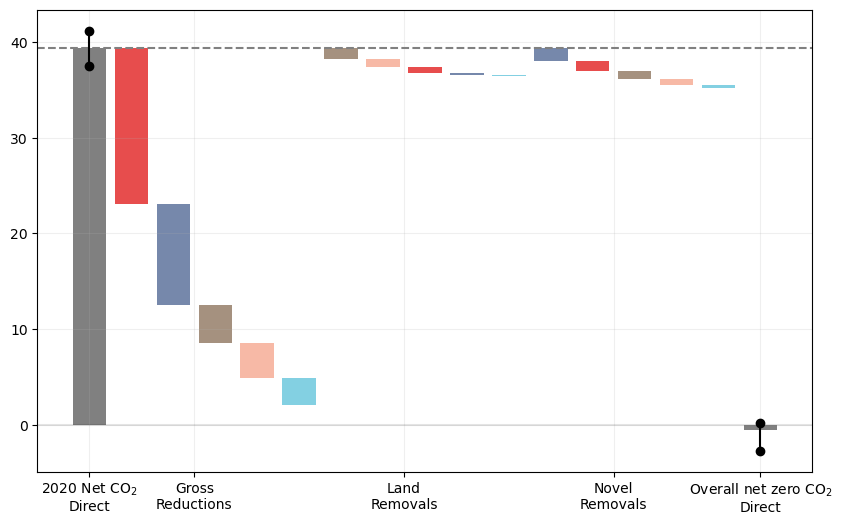

In [72]:
fig, ax = plt.subplots(
    figsize=(10, 6)
)

# First we want to plot the two end states (in grey)
## Start with the medians
ax.bar(
    x=0,
    height=compiled_data_for_plot['net_emissions_2020'].median(),
    color='grey'
)
ax.bar(
    x=16,
    height=compiled_data_for_plot['net_emissions_netzero'].median(),
    color='grey'
)
## Now plot the errorbars
ax.errorbar(
    x=[0,0],
    y=[
        compiled_data_for_plot['net_emissions_2020'].quantile(q=0.25),
        compiled_data_for_plot['net_emissions_2020'].quantile(q=0.75)    
    ],
    marker='o',
    color='black'
)
ax.errorbar(
    x=[16,16],
    y=[
        compiled_data_for_plot['net_emissions_netzero'].quantile(q=0.25),
        compiled_data_for_plot['net_emissions_netzero'].quantile(q=0.75)    
    ],
    marker='o',
    color='black'
)

# Plot the emission reductions
starting_i = 1
previous_med = compiled_data_for_plot['net_emissions_2020'].median()
sets = [
    'reduction_gross',
    'reduction_land',
    'reduction_novel'
]
for col_sets in sets:
    previous_med = compiled_data_for_plot['net_emissions_2020'].median()
    cols_to_plot = [
        x for x in compiled_data_for_plot.columns if col_sets in x
    ]
    compiled_vals = compiled_data_for_plot[cols_to_plot].median().sort_values()
    for i, index in enumerate(compiled_vals.index):
        if i>0:
            previous_med += compiled_vals.iloc[i-1]
        reg_name = index.split('_')[-1]
        ax.bar(
            x=starting_i,
            bottom=previous_med,
            height=compiled_vals.iloc[i],
            color=region_colors[reg_name]
        )
        starting_i += 1
    #previous_med += compiled_vals.iloc[i]
#previous_med = compiled_data_for_plot['net_emissions_2020'].median()
#cols_to_plot = [
#    x for x in compiled_data_for_plot.columns if 'reduction_land' in x
#]
##compiled_vals = compiled_data_for_plot[cols_to_plot].median().sort_values()
#for i, index in enumerate(compiled_vals.index):
#    if i>0:
##        previous_med += compiled_vals.iloc[i-1]
#    reg_name = index.split('_')[-1]
#    ax.bar(
#        x=starting_i,
#        bottom=previous_med,
#        height=compiled_vals.iloc[i],
#        color=region_colors[reg_name]
#    )
#    starting_i += 1
#
#previous_med = compiled_data_for_plot['net_emissions_2020'].median()
#cols_to_plot = [
#    x for x in compiled_data_for_plot.columns if 'reduction_novel' in x
#]
#compiled_vals = compiled_data_for_plot[cols_to_plot].median().sort_values()
#for i, index in enumerate(compiled_vals.index):
#    if i>0:
#        previous_med += compiled_vals.iloc[i-1]
#    reg_name = index.split('_')[-1]
#    ax.bar(
#        x=starting_i,
#        bottom=previous_med,
 #       height=compiled_vals.iloc[i],
 #       color=region_colors[reg_name]
  #  )
   # starting_i += 1

# Plot formatting
ax.grid(alpha=0.2)
ax.axhline(0, color='black', alpha=0.1)
ax.set_xticks(
    [0, 2.5, 7.5, 12.5, 16]
)
ax.set_xticklabels(
    [
        '2020 Net CO$_2$\nDirect',
        'Gross\nReductions',
        'Land\nRemovals',
        'Novel\nRemovals',
        'Overall net zero CO$_2$\nDirect'
    ]
)
ax.axhline(compiled_data_for_plot['net_emissions_2020'].median(), color='grey', linestyle='dashed')

In [56]:
previous_med

-3.5557336206636148

In [73]:
compiled_data_for_plot

net_emissions_2020  \
model             scenario                                    
AIM/CGE 2.1       CD-LINKS_NPi2020_400            38.413514   
AIM/CGE 2.2       EN_NPi2020_300f                 42.213500   
                  EN_NPi2020_600                  42.213499   
COFFEE 1.1        EN_NPi2020_400                  37.588756   
GCAM 5.3          R_MAC_30_n0                     41.219164   
...                                                     ...   
WITCH 5.0         EN_NPi2020_450f                 37.424381   
                  EN_NPi2020_500                  37.424380   
                  EN_NPi2020_500f                 37.424390   
WITCH-GLOBIOM 4.4 CD-LINKS_NPi2020_1000           40.884831   
                  CD-LINKS_NPi2020_400            40.884651   

                                         net_emissions_2100  \
model             scenario                                    
AIM/CGE 2.1       CD-LINKS_NPi2020_400            -9.437375   
AIM/CGE 2.2       EN_NPi2020_300f                -10.275740   
                  EN_NPi2020_600                  -0.165976   
COFFEE 1.1        EN_NPi2020_400                  -1.202552   
GCAM 5.3          R_MAC_30_n0                     -0.986432   
...                                                     ...   
WITCH 5.0         EN_NPi2020_450f                -14.572006   
                  EN_NPi2020_500                  -2.458633   
                  EN_NPi2020_500f                -14.121366   
WITCH-GLOBIOM 4.4 CD-LINKS_NPi2020_1000           -6.823433   
                  CD-LINKS_NPi2020_400           -13.172593   

                                         net_emissions_netzero  \
model             scenario                                       
AIM/CGE 2.1       CD-LINKS_NPi2020_400               -8.835162   
AIM/CGE 2.2       EN_NPi2020_300f                    -4.191906   
                  EN_NPi2020_600                     -4.350539   
COFFEE 1.1        EN_NPi2020_400                     -0.623646   
GCAM 5.3          R_MAC_30_n0                         1.406872   
...                                                        ...   
WITCH 5.0         EN_NPi2020_450f                    -4.200044   
                  EN_NPi2020_500                     -4.532144   
                  EN_NPi2020_500f                    -4.364547   
WITCH-GLOBIOM 4.4 CD-LINKS_NPi2020_1000              -0.541293   
                  CD-LINKS_NPi2020_400               -1.926646   

                                         reduction_gross_2020_netzero_R5ASIA  \
model             scenario                                                     
AIM/CGE 2.1       CD-LINKS_NPi2020_400                            -11.777512   
AIM/CGE 2.2       EN_NPi2020_300f                                 -17.319134   
                  EN_NPi2020_600                                  -17.089845   
COFFEE 1.1        EN_NPi2020_400                                  -12.710921   
GCAM 5.3          R_MAC_30_n0                                     -19.060557   
...                                                                      ...   
WITCH 5.0         EN_NPi2020_450f                                 -11.833975   
                  EN_NPi2020_500                                  -12.248451   
                  EN_NPi2020_500f                                 -11.809328   
WITCH-GLOBIOM 4.4 CD-LINKS_NPi2020_1000                           -14.948582   
                  CD-LINKS_NPi2020_400                            -15.138123   

                                         reduction_gross_2020_netzero_R5LAM  \
model             scenario                                                    
AIM/CGE 2.1       CD-LINKS_NPi2020_400                            -2.951820   
AIM/CGE 2.2       EN_NPi2020_300f                                 -3.190566   
                  EN_NPi2020_600                                  -3.314555   
COFFEE 1.1        EN_NPi2020_400                                  -5.718870   
GCAM 5.3          R_MAC_30_